Experiment ID: 1
temperature: 30.94
gas: 16293.0
humidity: 41.0
barometer: 1028.85
Liverpool temperature: 5.45
Timestamp: 12-11 20:50:10
Experiment ID: 2
temperature: 30.94
gas: 16155.0
humidity: 41.0
barometer: 1028.87
Liverpool temperature: 5.45
Timestamp: 12-11 20:50:15
Experiment ID: 3
temperature: 30.94
gas: 16255.0
humidity: 41.0
barometer: 1028.85
Liverpool temperature: 5.45
Timestamp: 12-11 20:50:21
Experiment ID: 4
temperature: 30.94
gas: 16167.0
humidity: 41.0
barometer: 1028.85
Liverpool temperature: 5.45
Timestamp: 12-11 20:50:26
Experiment ID: 5
temperature: 30.94
gas: 16408.0
humidity: 41.0
barometer: 1028.8
Liverpool temperature: 5.45
Timestamp: 12-11 20:50:31
Experiment ID: 6
temperature: 30.94
gas: 16408.0
humidity: 41.0
barometer: 1028.83
Liverpool temperature: 5.45
Timestamp: 12-11 20:50:36
Experiment ID: 7
temperature: 30.94
gas: 16408.0
humidity: 41.0
barometer: 1028.8
Liverpool temperature: 5.45
Timestamp: 12-11 20:50:41
Experiment ID: 8
temperature: 30.94
gas: 16

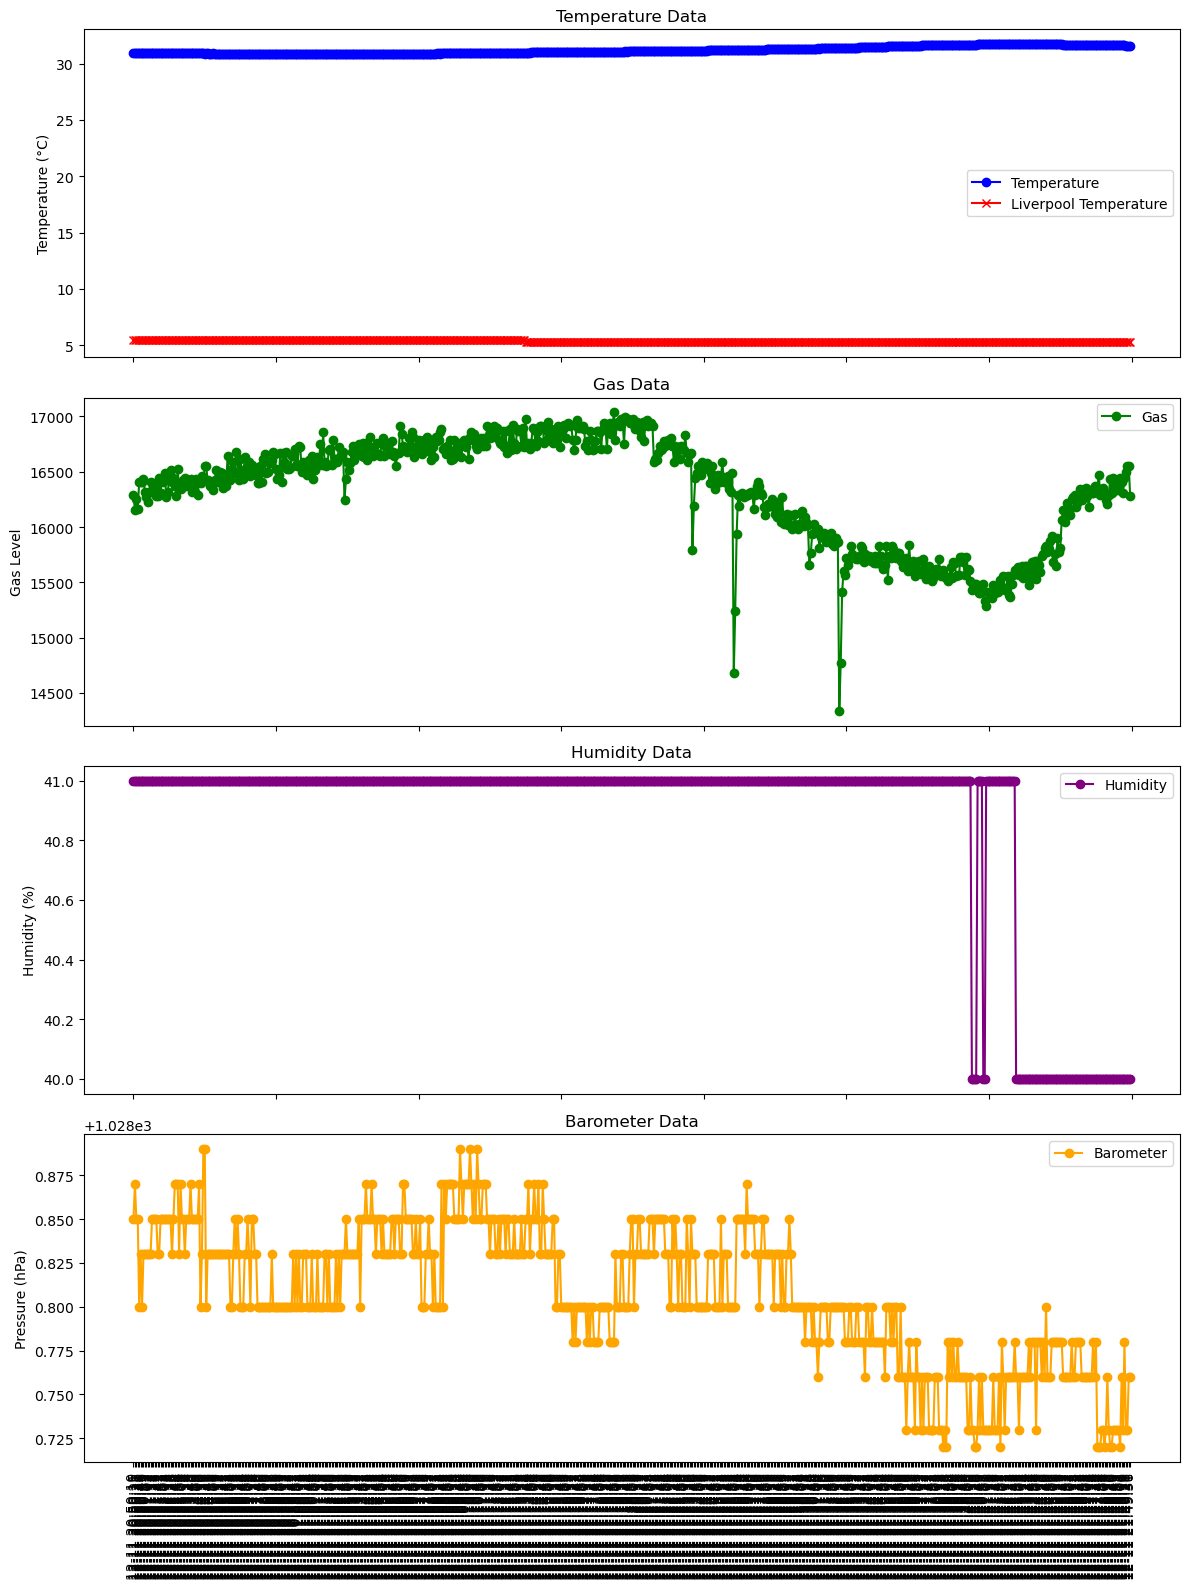

In [ ]:
# import the neccessary libraries
import sqlite3
import paho.mqtt.subscribe as subscribe
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime  # use to record the exact time
import time
import requests

dongyangtopics = ['dongyang_temp', 'dongyang_gas', 'dongyang_humidity', 'dongyang_barometer']

# set the counting times
counts = 1000

temperature = []
gas = []
times = []
humidity = []
barometer = []
liverpool_temperature = []  # the temperature data from Liverpool(getting from online API)
experiment_IDs = []  # List to store experiment IDs

API_KEY = '22a18c6ef80c9dd24ea87b6490b91603'
CITY = 'Liverpool,GB'
WEATHER_URL = f"http://api.openweathermap.org/data/2.5/weather?q={CITY}&appid={API_KEY}&units=metric"

# Create SQLite database and table
conn = sqlite3.connect('dongyangdata.db')
cursor = conn.cursor()

# Create table if not exists
cursor.execute('''
    CREATE TABLE IF NOT EXISTS data (
        experiment_ID INTEGER,
        timestamp TEXT,
        temperature REAL,
        gas REAL,
        humidity REAL,
        barometer REAL,
        liverpool_temperature REAL,
        place TEXT
    )
''')
conn.commit()

# Function to get the current temperature in Liverpool from the weather API
def get_liverpool_temperature():
    try:
        response = requests.get(WEATHER_URL)
        data = response.json()
        if response.status_code == 200 and 'main' in data:
            return data['main']['temp'] 
        else:
            print("Liverpool temperature could not acquired")
            return None
    except Exception as e:
        print(f"errer: {e}")
        return None

# Collect data in a loop for 'counts' number of times
for n in range(counts):
    # getting data from mqtt server inside the loop to fetch fresh data each time
    dongyangdata = subscribe.simple(dongyangtopics, hostname="pf-eveoxy0ua6xhtbdyohag.cedalo.cloud", retained=False, msg_count=len(dongyangtopics))

    data = []
    for a in dongyangdata:
        data.append(float(a.payload))

    # Get the current temperature in Liverpool
    liverpool_temp = get_liverpool_temperature()

    # append the new data to the lists
    temperature.append(float(data[0]))
    gas.append(float(data[1]))
    humidity.append(float(data[2]))
    barometer.append(float(data[3]))
    liverpool_temperature.append(liverpool_temp)
    times.append(datetime.now().strftime("%m-%d %H:%M:%S"))
    experiment_IDs.append(n + 1)  # Add the experiment ID starting from 1

    # Insert the data into SQLite database
    cursor.execute('''
        INSERT INTO data (experiment_ID, timestamp, temperature, gas, humidity, barometer, liverpool_temperature, place)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    ''', (experiment_IDs[-1], times[-1], temperature[-1], gas[-1], humidity[-1], barometer[-1], liverpool_temperature[-1], 'dongyangHome'))
    conn.commit()

    # print real-time data after each collection
    print(f"Experiment ID: {experiment_IDs[-1]}")
    print(f"temperature: {temperature[-1]}")
    print(f"gas: {gas[-1]}")
    print(f"humidity: {humidity[-1]}")
    print(f"barometer: {barometer[-1]}")
    print(f"Liverpool temperature: {liverpool_temperature[-1]}")
    print(f"Timestamp: {times[-1]}")
    time.sleep(1)  # the time(s) delay after one collection

# create the pandas database and name the columns
df = pd.DataFrame({
    'experiment_ID': experiment_IDs,  # Include experiment_ID here
    'timestamp': times,
    'temperature': temperature,
    'gas': gas,  
    'humidity': humidity,
    'barometer': barometer,
    'liverpool_temperature': liverpool_temperature,
    'place': ['dongyangHome'] * len(times),
})

# Save the data to CSV
df.to_csv('dongyangdata.csv', index=False)

# read the csv data
df = pd.read_csv('dongyangdata.csv')

# plot the graph
plt.figure(figsize=(12, 16))

# graph1:temperature
plt.subplot(4, 1, 1)
plt.plot(df['temperature'], label='Temperature', marker='o', color='blue')
plt.plot(df['liverpool_temperature'], label='Liverpool Temperature', marker='x', color='red')
plt.title("Temperature Data")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=90)
plt.legend()
plt.tick_params(labelbottom=False)

# graph2:gas
plt.subplot(4, 1, 2)
plt.plot(df['gas'], label='Gas', marker='o', color='green')
plt.title("Gas Data")
plt.ylabel("Gas Level")
plt.xticks(rotation=90)
plt.legend()
plt.tick_params(labelbottom=False)

# graph3:humidity
plt.subplot(4, 1, 3)
plt.plot(df['humidity'], label='Humidity', marker='o', color='purple')
plt.title("Humidity Data")
plt.ylabel("Humidity (%)")
plt.xticks(rotation=90)
plt.legend()
plt.tick_params(labelbottom=False)

# graph4:barometer
plt.subplot(4, 1, 4)
plt.plot(df['timestamp'], df['barometer'], label='Barometer', marker='o', color='orange')
plt.title("Barometer Data")
plt.ylabel("Pressure (hPa)")
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()# Adjust layout to prevent overlap
plt.show()# Show the plots

# Close the SQLite connection
conn.close()
